In [18]:
import pypyodbc as odbc
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [5]:
DRIVER_NAME = "SQL Server"
SERVER_NAME = "DESKTOP-PJBN9BQ\\SQLEXPRESS"
DATABASE_NAME = "Diabetes"

CONNECTION_STRING = f"""
    DRIVER={{{DRIVER_NAME}}};
    SERVER={SERVER_NAME};
    DATABASE={DATABASE_NAME};
    Trust_Connection=yes;
"""

Conn = odbc.connect(CONNECTION_STRING)

(35346, 35346)


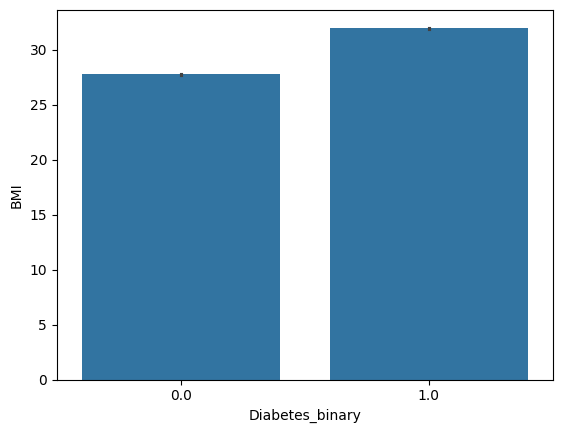

In [8]:
cursor = Conn.cursor()
tables_list = list(cursor.tables())

table_name = "diabetes_binary_split_health_indicators_BRFSS2015"
query = "SELECT * FROM {}".format(table_name) # SQL qury, filter here not using pandas

cursor.execute(query)

table = cursor.fetchall()
columns = ["Diabetes_binary","HighBP","HighChol","CholCheck","BMI","Smoker","Stroke","HeartDiseaseorAttack","PhysActivity","Fruits","Veggies","HvyAlcoholConsump","AnyHealthcare","NoDocbcCost","GenHlth","MentHlth","PhysHlth","DiffWalk","Sex","Age","Education","Income"]

table_dataframe = pd.DataFrame(table, columns= columns)

for column in columns:
    table_dataframe[str(column)] = table_dataframe[str(column)].astype(float)

#sns.barplot(x = "Diabetes_binary",y = "BMI", data = table_dataframe)

# checking if set is balanced
print((len(table_dataframe[table_dataframe.Diabetes_binary == 1]),len(table_dataframe[table_dataframe.Diabetes_binary == 0]) ))

In [27]:
columns_without_first = ["HighBP","HighChol","CholCheck","BMI","Smoker","Stroke","HeartDiseaseorAttack","PhysActivity","Fruits","Veggies","HvyAlcoholConsump","AnyHealthcare","NoDocbcCost","GenHlth","MentHlth","PhysHlth","DiffWalk","Sex","Age","Education","Income"]
Y = table_dataframe["Diabetes_binary"].values
X = table_dataframe[columns_without_first].values

column_transformator = ColumnTransformer(transformers = [("encoder", OneHotEncoder(), [])], remainder= "passthrough")
X = np.array(column_transformator.fit_transform(X))

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 101)


model = LinearRegression()
model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)
print(model.coef_)

[ 0.15767648  0.10469426  0.15957115  0.01193016  0.00152392  0.03135367
  0.04889454 -0.00768154 -0.00990635 -0.00665023 -0.12375834  0.00061461
 -0.00112011  0.10480215 -0.00078459 -0.00153448  0.02664256  0.04821468
  0.0255554  -0.00624309 -0.01049518]
